<a href="https://colab.research.google.com/github/dwgb93/MA797-Final-Project/blob/main/MA_797_Final_Project_Bates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project
#Dylan, A, A

We are going to use transfer learning on I̶n̶c̶e̶p̶t̶i̶o̶n̶    VGG to predict pictures of animals. 
The below code is modified from [keras.io/applications](keras.io/applications) to fine-tune VGG-16 on a new set of classes.


In [ ]:
# imports
#from keras.applications.inception_v3 import InceptionV3 #God I love Keras sometimes
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import SGD

# need the new one for the confusion matrix
!pip install scikit-learn==0.22

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


     |████████████████████████████████| 7.0MB 6.6MB/s 
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# zip file containing 2 folders: train, test 
# The training data consists of images in 16 classes
# Testing data consists of SEQUENCES of images
# I went out of my way to separate whole sequences into train and test
!unzip -q "/content/drive/My Drive/Colab Notebooks/ML Final Project/data.zip" # where data is stored might have changed. Change drive to gdrive to fix
#!unzip -q "/content/drive/My Drive/Colab Notebooks/dataBroad.zip"

#Part 1: Data Analysis - if rerunning, run from here Ctrl+F10

*   How many training images?
*   How many testing images?



In [ ]:
import os
import numpy as np
EPOCHS = 32 # up from 20 # Training will automatically stop when val loss increases
BATCH_SIZE = 64 # may increase this, for better gradient

TRAIN_DIR = '/content/data/training'
TEST_DIR = '/content/data/test'

# Sanity check
target_names = [item for item in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, item))]
nb_train_samples = sum([len(files) for _, _, files in os.walk(TRAIN_DIR)])  
nb_test_samples = sum([len(files) for _, _, files in os.walk(TEST_DIR)])
total_nb_samples = nb_train_samples + nb_test_samples

nb_classes = len(target_names)      # number of output classes

print('Training a CNN Multi-Classifier Model ......')
print('\n - names of classes: ', target_names, '\n - # of classes: ', nb_classes)
print(' - # of training samples: ', nb_train_samples, '\n - split into  ', 0.2*nb_train_samples, ' validation samples'
      '\n - # of test samples: ', nb_test_samples,
       '\n - total # of samples: ', total_nb_samples, '\n - train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
     ' %', '\n - # of epochs: ', EPOCHS, '\n - batch size: ', BATCH_SIZE)

#train on the entire set every epoch
STEPS_PER_EPOCH = np.ceil(nb_train_samples/BATCH_SIZE) #number of batches per epoch
VALIDATION_STEPS = np.ceil(0.2*nb_train_samples/BATCH_SIZE)

print("Steps per epoch: ", STEPS_PER_EPOCH)
print("Validation steps: ", VALIDATION_STEPS)

Training a CNN Multi-Classifier Model ......

 - names of classes:  ['1.60-Red_Fox', '1.59-Wild_Boar', '1.10-Ocelot', '1.07-Red_Brocket_Deer', '1.08-White-nosed_Coati', '1.58-Roe_Deer', '1.14-Red_Squirrel', '1.03-Collared_Peccary', '1.80-Coiban_Agouti', '1.27-White_Tailed_Deer', '1.22-Bird_spec', '1.02-Agouti', '1.63-European_Hare', '1.56-Mouflon', '1.57-Red_Deer', '1.25-Great_Tinamou'] 
 - # of classes:  16
 - # of training samples:  566 
 - split into   113.2  validation samples
 - # of test samples:  1057 
 - total # of samples:  1623 
 - train ratio: 34.87  % 
 - # of epochs:  32 
 - batch size:  64
Steps per epoch:  9.0
Validation steps:  2.0


#Part 2: Creating the Model

Import the VGG16 model. Inception tries to classify images into 1000 different categories. We only have 16. So we're going to remove the last layer, freeze the model, and add a 16 neuron final layer to train.

In [ ]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)
#top = false removes the last dense (output) later
#Last layer is randomly initialized

n = nb_classes #NumClasses

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) # sometimes removed or modified

# and a logistic layer -- let's say we have numClasses n
predictions = Dense(n, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#model.summary() # It's not as deep as Inception, but it'll do

# first: train only the top (last) layers (which were randomly initialized)
# i.e. freeze all convolutional VGG layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
# optimizer changed to adam from rmsprop because it's spoopier

# Save the best model.
checkpoint = ModelCheckpoint('best_defaultD5_model.hdf5', monitor='val_loss', save_best_only=True, period=1)

# stop training if it's overfitting # may need to increase regularization
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=12, verbose=1, mode='auto')
CALLBACKS=[checkpoint,early]

# train the model on the new data for a few epochs

#Part 3: Image Regularization/Augmentation

VGG16 expects a 224x224 RGB image. So we resize each image and scale each channel from [0,255] to [-1,1].

Initial tests were run as is. Later on, images were rotated, reflected, sheared, scaled, and translated to help avoid overfitting.

Training and validation images were drawn from the same folder with a random 80/20 split.

In [ ]:
# required image size for VGG16. UGH, that's less than 2% of full HD images
WIDTH = 224
HEIGHT = 224

# potential image augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=10, # sometimes these 5 rows are commented out
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2) #TURN THIS ONE BACK ON


validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical',
    subset='training')

# uses same datagen as training, since it's from the same set
validation_generator = validation_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical',
    subset='validation')

# No augmentation here. Just normalization.
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

naive_test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE,
		class_mode='categorical')

# real test generator below

Found 457 images belonging to 16 classes.
Found 109 images belonging to 16 classes.
Found 1057 images belonging to 16 classes.


#Part 4: Training the Model

Optional: saving the model for later use.
We are currently running the model for 20 epochs, but that may change if it's still converging.

Note that unless image augmentation is used in Part 3, validation accuracy will be much lower than testing accuracy, due to the size of the dataset.

Model has started training
Epoch 00021: early stopping


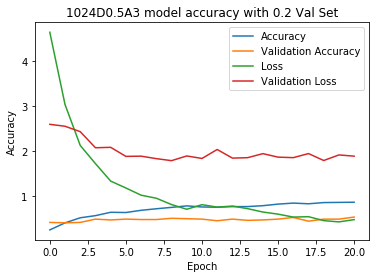

In [ ]:
#Train the model
#MODEL_FILE = 'Default.model'

print("Model has started training")
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=CALLBACKS,
    verbose=0)
  

#model.save(MODEL_FILE)

import matplotlib.pyplot as plt
plt.plot(history.history["acc"])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("1024D0.5A3 model accuracy with 0.2 Val Set")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"]) #Is this loss?
plt.show()

#Part 5: Fine Tuning the model

At this point, the top layers are well trained and we can start fine-tuning convolutional layers from VGG16. We will freeze the bottom (first) few layers and train the remaining top layers.

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)


# we chose to train the top 2 convolutional blocks, i.e. we will freeze
# the first 11 layers and unfreeze the rest: 
for layer in model.layers[:11]:
   layer.trainable = False
for layer in model.layers[11:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics = ['accuracy'])

# Save the best model.
checkpointF = ModelCheckpoint('best_1024_model.hdf5', monitor='val_loss', save_best_only=True, period=1)

# stop training sooner if it's overfitting # may need to increase regularization
earlyF = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=1, mode='auto')

CALLBACKSF=[checkpointF,earlyF]

# we train our model again (this time fine-tuning the top 2 convolutional blocks
# alongside the top Dense layers, for only a few epochs
history_fine = model.fit(train_generator,
                         epochs=EPOCHS,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_generator,
                         validation_steps=VALIDATION_STEPS,
                         callbacks=CALLBACKSF)

# Naive test accuracy over entire test set: probably very low
#print('Out of Sample Accuracy: ', model.evaluate(naive_test_generator, verbose=True))

# To be fair, if I showed you these images, you wouldn't be able to tell what's
# in them either

Epoch 21/32
8/8 [==============================] - 28s 4s/step - loss: 0.4001 - acc: 0.8588 - val_loss: 1.9691 - val_acc: 0.5138
Epoch 22/32
8/8 [==============================] - 23s 3s/step - loss: 0.3861 - acc: 0.8773 - val_loss: 2.0568 - val_acc: 0.5321
Epoch 00022: early stopping


#Part 6: Using Sequences to Test

Up until now, we've been viewing the sequences as a bad thing. More than 80% of images in a given sequence can be bad, with the animal obscured, out of focus, or out of frame. But the images are still labeled, as if there's a deer there.

That is a large reason why the model failed to learn anything when run on the full dataset. However, since entire sequences are labeled as the same animal, we can use this a prori knowledge to increase our confidence in predicting the label of an entire sequence, which should significantly raise our out of sample testing accuracy.

In [ ]:
# function to determine animal in a sequence by averaging weights
def calculate_sequence_average(animalWeights):
    newArray = np.matmul(np.ones(len(animalWeights)),animalWeights)
    return newArray/sum(newArray)

# more aggressive function with higher confidence and (hopefully) higher accuracy
def calculate_sequence_weights(animalWeights):
    newArray = np.ones(n)
    for i in range(len(animalWeights)):
        newArray = np.multiply(newArray,animalWeights[i])

    return newArray/sum(newArray)

# VERY aggressive weight function 
def calculate_sequence_max(animalWeights):
    newArray = animalWeights.flatten()

    return (np.argmax(newArray) % n)


# we're going to create a list of all the animals and all the sequences
# as well as the size of the directories they're in, and feed them one
# at a time to the two functions above
list_of_animals = []
list_of_directories = []
number_of_sequence =[]
length_of_sequence = []

# names of folders in a directory of a directory:
for animal in os.listdir(TEST_DIR):
    list_of_animals.append(animal)
    list_of_directories.append(os.path.join(TEST_DIR, animal))
    length_of_sequence = []

    for sequence in os.listdir(os.path.join(TEST_DIR, animal)):
        length_of_sequence.append(len([name for name in os.listdir(os.path.join(os.path.join(TEST_DIR, animal), sequence)) if os.path.isfile(os.path.join(os.path.join(os.path.join(TEST_DIR, animal), sequence),name))]))
    number_of_sequence.append(length_of_sequence)

print(list_of_directories)
totalSequences =  sum([len(elements) for elements in number_of_sequence])

# For some reason, it was shuffling the order and marking nearly everything wrong
labels = ['1.02-Agouti',
          '1.03-Collared_Peccary',
          '1.07-Red_Brocket_Deer',
          '1.08-White-nosed_Coati',
          '1.10-Ocelot',
          '1.14-Red_Squirrel',
          '1.22-Bird_spec',
          '1.25-Great_Tinamou',
          '1.27-White_Tailed_Deer',
          '1.56-Mouflon',
          '1.57-Red_Deer',
          '1.58-Roe_Deer',
          '1.59-Wild_Boar',
          '1.60-Red_Fox',    
          '1.63-European_Hare',  
          '1.80-Coiban_Agouti']

labels2 = ['1.08-White-nosed_Coati', # Used for the broad 10 species categories
          '1.10-Ocelot',
          '1.14-Red_Squirrel',
          '1.56-Mouflon',
          '1.60-Red_Fox',    
          '1.63-European_Hare',  
          'Agouti',
          'Birds',
          'Deer',
          'Pigs']

# counters for my three sequence metrics
# Number of images correct
averageCounter = 0
correctCounter = 0
maxCounter = 0
# Number of sequences correct
averageCounterS = 0
correctCounterS = 0
maxCounterS = 0

# sanity check - should be the same as Naive_test_generator results
myCounter = 0

confusionTrue = []
confusionPred = []

for animal in range(len(list_of_animals)):
    TEST_DIR_NEW = list_of_directories[animal]

    # new test generator specifically made for sequences
    test_generator = test_datagen.flow_from_directory(
    TEST_DIR_NEW,
    batch_size = 1,
    target_size=(HEIGHT, WIDTH),
		class_mode='categorical',
    shuffle = False)
   
    #model.predict gives just the output
    animalWeights = model.predict(test_generator)

    for i in range(len(animalWeights)):
        k = np.argmax(animalWeights[i])
        
        if labels[k] == list_of_animals[animal]:
            myCounter = myCounter+1

        # For the confusion matrix
        confusionTrue.append(list_of_animals[animal])
        confusionPred.append(labels[k])


    for m in range(len(number_of_sequence[animal])):
        # my three sequence weight calculations # Should improve accuracy
        animalArray = calculate_sequence_weights(animalWeights[:number_of_sequence[animal][m]])
        animalArray2 = calculate_sequence_average(animalWeights[:number_of_sequence[animal][m]])
        k = np.argmax(animalArray)
        k2 = np.argmax(animalArray2)
        k3 = calculate_sequence_max(animalWeights[:number_of_sequence[animal][m]])
        
        #print("Sequence Prediction: ",labels[k], "Average Prediction: ", labels[k2]," Actual: ", list_of_animals[animal], " Max: ", labels[k3])
        if labels[k] == list_of_animals[animal]:
            correctCounterS = correctCounterS+1
            correctCounter = correctCounter+ len(animalWeights[:number_of_sequence[animal][m]])

        if labels[k2] == list_of_animals[animal]:
            averageCounterS = averageCounterS +1
            averageCounter = averageCounter+ len(animalWeights[:number_of_sequence[animal][m]])

        if labels[k3] == list_of_animals[animal]:
            maxCounterS = maxCounterS +1
            maxCounter = maxCounter + len(animalWeights[:number_of_sequence[animal][m]])

        # remove first sequence and recalculate on next
        animalWeights = animalWeights[number_of_sequence[animal][m]:]


print('Out of Sample Accuracy: ', model.evaluate(naive_test_generator, verbose=True), ' check: ', myCounter/nb_test_samples) #these should be the same
# My Three Metrics:
print("Final Out of Sample Sequence Accuracy: ", correctCounterS/totalSequences, " Average Accuracy: ", averageCounterS/totalSequences, " Max Acc: ", maxCounterS/totalSequences)


['/content/data/test/1.60-Red_Fox', '/content/data/test/1.59-Wild_Boar', '/content/data/test/1.10-Ocelot', '/content/data/test/1.07-Red_Brocket_Deer', '/content/data/test/1.08-White-nosed_Coati', '/content/data/test/1.58-Roe_Deer', '/content/data/test/1.14-Red_Squirrel', '/content/data/test/1.03-Collared_Peccary', '/content/data/test/1.80-Coiban_Agouti', '/content/data/test/1.27-White_Tailed_Deer', '/content/data/test/1.22-Bird_spec', '/content/data/test/1.02-Agouti', '/content/data/test/1.63-European_Hare', '/content/data/test/1.56-Mouflon', '/content/data/test/1.57-Red_Deer', '/content/data/test/1.25-Great_Tinamou']
Found 10 images belonging to 1 classes.
Found 45 images belonging to 3 classes.
Found 3 images belonging to 1 classes.
Found 24 images belonging to 2 classes.
Found 81 images belonging to 9 classes.
Found 170 images belonging to 6 classes.
Found 43 images belonging to 4 classes.
Found 18 images belonging to 2 classes.
Found 100 images belonging to 6 classes.
Found 77 imag

In [ ]:
# Formatted output for LaTeX tables
print(len(history.history['acc']), "&",format(history.history['acc'][-1], '.4f'), "&", format(history.history['val_acc'][-1], '.4f'), '&', format(myCounter/nb_test_samples, '.4f'), '\\\\')

print(format(myCounter/nb_test_samples, '.4f'), '&', format(averageCounterS/totalSequences, '.4f'), '&', format(correctCounterS/totalSequences, '.4f'), '&', format(maxCounterS/totalSequences, '.4f'), '\\\\')

print(format(myCounter/nb_test_samples, '.4f'), '&', format(averageCounter/nb_test_samples, '.4f'), '&', format(correctCounter/nb_test_samples, '.4f'), '&', format(maxCounter/nb_test_samples, '.4f'), '\\\\')


21 & 0.8541 & 0.5229 & 0.6310 \\
0.6310 & 0.6230 & 0.6721 & 0.7049 \\
0.6310 & 0.7162 & 0.7294 & 0.7143 \\


<Figure size 720x720 with 0 Axes>

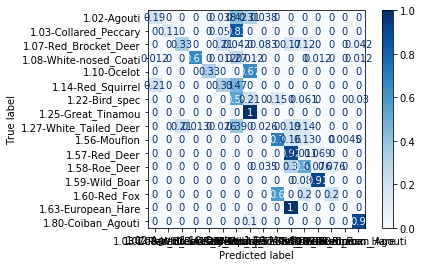

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm=confusion_matrix(confusionTrue, confusionPred, labels=labels,normalize='true')
plt.figure(figsize=(10,10)) #Yeah, that's supposed to make it big. RIP

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp = disp.plot(cmap=plt.cm.Blues)

plt.show()

# Apparently everything is a Bird now.

In [ ]:
# Comletely out of sample test for the lulz
img_path = 'drive/My Drive/Colab Notebooks/ML Final Project/IsThisADeer.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)

j = np.argmax(preds)
print("it's a", labels[j]) # Usually Bird for 16 species and Deer for 10


it's a 1.57-Red_Deer
